In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import dill as dill
import json

from Utilities.Preprocessors import DataPreprocessor
from Utilities.Transformers import MultilabelTransformer
from Utilities.Transformers import LocationTransformer
from Utilities.Transformers import ParkingTransformer
from sklearn.preprocessing import FunctionTransformer
from Utilities.Common import check_models, check_overfitting, get_fold, get_metrics

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance


from Utilities.Transformers import ScalerTransformer
from Utilities.Transformers import FeatureSelector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
#import Utilities

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mainify(obj):
    """If obj is not defined in __main__ then redefine it in 
    main so that dill will serialize the definition along with the object"""
    if obj.__module__ != "__main__":
        import __main__
        import inspect
        s = inspect.getsource(obj)
        co = compile(s, '<string>', 'exec')
        exec(co, __main__.__dict__)

In [3]:
N_FOLDS = 5
LOCATIONS_POSTALCODES_PATH = "Utilities/PostalcodesSearch/locations_postalcodes.json"
SCORING = {'R2': 'r2',
           'explained_variance': 'explained_variance',
           'MSE': 'neg_mean_squared_error',
           'MAE': 'neg_mean_absolute_error'}

In [4]:
#Переопределение объектов из окружения которые не определены в __main__ для их сереализации в dill.
mainify(DataPreprocessor)
mainify(LocationTransformer)
mainify(MultilabelTransformer)
mainify(FeatureSelector)
mainify(ScalerTransformer)

In [5]:
df1 = pd.read_csv("Data/kursk_apartments.csv", index_col=0)
df1.shape

(215, 23)

In [6]:
outlier_cols = ['Цена', 'Общая площадь']
df1 = df1[(np.abs(stats.zscore(df1[outlier_cols])) < 2).all(axis=1)]
df1.dropna(subset=outlier_cols, how='all', inplace=True)
df1.shape

(203, 23)

In [7]:
drop_columns = ['Ремонт', 'Мебель', 'Техника', 'Тип дома']

passthrough_columns = ['Общая площадь']

selected_columns = ['price__Цена', 'passthrough__Общая площадь',
                    'postalcode__Почтовый индекс_305000',
                    'postalcode__Почтовый индекс_305001',
                    'postalcode__Почтовый индекс_305004',
                    'postalcode__Почтовый индекс_305005',
                    'postalcode__Почтовый индекс_305006',
                    'postalcode__Почтовый индекс_305016',
                    'postalcode__Почтовый индекс_305018',
                    'postalcode__Почтовый индекс_305021',
                    'renovation__дизайнерский', 'renovation__евро',
                    'house_type__монолитный',
                    'furniture__хранение одежды','furniture__кухня',
                    'appliances__водонагреватель', 'appliances__кондиционер', 'appliances__микроволновка', 'appliances__nan',
                    'appliances__посудомоечная машина', 'appliances__стиральная машина', 'appliances__телевизор']


with open(LOCATIONS_POSTALCODES_PATH, encoding='utf-8') as file:
    locations_postalcodes = json.load(file)

column_preprocessor = ColumnTransformer(
    [
        ('price', FunctionTransformer(np.log1p, inverse_func=np.exp), ['Цена']),
        ('passthrough', 'passthrough', passthrough_columns),
        ('postalcode', LocationTransformer(locations_postalcodes, min_occurances=10), 'Улица'),
        ('room_type', MultilabelTransformer(), 'Тип комнат'),
        ('renovation', MultilabelTransformer(), 'Ремонт'),
        ('house_type', MultilabelTransformer(), 'Тип дома'),
        ('furniture', MultilabelTransformer(), 'Мебель'),
        ('appliances', MultilabelTransformer(), 'Техника'),
        ('drop_transformed', 'drop', drop_columns)
    ],
    remainder='drop',
)
column_preprocessor.set_output(transform='pandas')


data_preprocessor = DataPreprocessor(
    column_preprocessor=column_preprocessor,
    selected_columns=selected_columns,
)

data_preprocessor.fit(df1)

In [8]:
with open('Outputs/data_preprocessor.dill', 'wb') as file:
    dill.dump(data_preprocessor, file, byref=False, recurse=True)

# Modeling

In [9]:
transformed = data_preprocessor.transform(df1)
transformed = shuffle(transformed, random_state=5).reset_index(drop=True)
transformed.head()

,price__Цена,passthrough__Общая площадь,postalcode__Почтовый индекс_305000,postalcode__Почтовый индекс_305001,postalcode__Почтовый индекс_305004,postalcode__Почтовый индекс_305005,postalcode__Почтовый индекс_305006,postalcode__Почтовый индекс_305016,postalcode__Почтовый индекс_305018,postalcode__Почтовый индекс_305021,...,house_type__монолитный,furniture__хранение одежды,furniture__кухня,appliances__водонагреватель,appliances__кондиционер,appliances__микроволновка,appliances__nan,appliances__посудомоечная машина,appliances__стиральная машина,appliances__телевизор
0,0.574623,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.574623,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.773694,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.613130,0.631884,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.773694,0.231884,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [10]:
X = transformed.drop(['price__Цена'], axis=1)
y = transformed['price__Цена']

## Baseline

In [11]:
models = dict()
models["sgdr"] = SGDRegressor()
models["linear"] = LinearRegression()
models["ridge"] = Ridge()
models["svr_linear"] = SVR(kernel='linear')
models["svr_rbf"] = SVR(kernel='rbf')
models["lasso"] = Lasso()
models["elastic"] = ElasticNet()
models["random_forest"] = RandomForestRegressor(n_estimators=100)
models['ensemble_ridge'] = BaggingRegressor(
    estimator=Ridge(),
    n_estimators=20,
    random_state=0
)
models['ensemble_svr_linear'] = BaggingRegressor(
    estimator=SVR(kernel='linear'),
    n_estimators=20,
    random_state=0
)
models['ensemble_linear'] = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=20,
    random_state=0
)

In [12]:
results = check_models(models, X, y, SCORING, n_folds=N_FOLDS)
results.sort_values(by='test_explained_variance', key=(
    lambda x: x.str['mean']), ascending=False).head(5)

,model,test_R2,test_explained_variance,test_MSE,test_MAE
3,svr_linear,"{'mean': 0.594, 'max': 0.775}","{'mean': 0.609, 'max': 0.79}","{'mean': -0.016, 'max': -0.011}","{'mean': -0.093, 'max': -0.082}"
9,ensemble_svr_linear,"{'mean': 0.593, 'max': 0.79}","{'mean': 0.606, 'max': 0.804}","{'mean': -0.016, 'max': -0.011}","{'mean': -0.093, 'max': -0.081}"
2,ridge,"{'mean': 0.589, 'max': 0.786}","{'mean': 0.605, 'max': 0.796}","{'mean': -0.017, 'max': -0.01}","{'mean': -0.094, 'max': -0.076}"
8,ensemble_ridge,"{'mean': 0.586, 'max': 0.773}","{'mean': 0.604, 'max': 0.782}","{'mean': -0.017, 'max': -0.01}","{'mean': -0.094, 'max': -0.078}"
10,ensemble_linear,"{'mean': 0.579, 'max': 0.772}","{'mean': 0.595, 'max': 0.784}","{'mean': -0.017, 'max': -0.01}","{'mean': -0.094, 'max': -0.077}"


## Tuning

In [13]:
grid_params = [
    {
        'model': Ridge(),
        'grid': {
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            'alpha': np.arange(0, 5, 0.1).tolist(),
            'fit_intercept': [True, False],
        }
    },
    {
        'model': BaggingRegressor(
            estimator=Ridge(),
            random_state=1
        ),
        'grid': {
            'estimator__alpha': np.arange(1, 2.5, 0.1).tolist(),
            'estimator__solver': ['auto', 'sparse_cg', 'sag', 'saga'],
            'estimator__fit_intercept': [True, False],
            'n_estimators': np.arange(20, 26, 1).tolist(),
            'max_features': np.arange(0.7, 1.01, 0.1).tolist(),
            'max_samples': np.arange(0.7, 1.01, 0.1).tolist()
        }
    },
    {
        'model': BaggingRegressor(
            estimator=SVR(kernel='linear'),
            max_features=0.9,
            n_estimators=22,
            random_state=1
        ),
        'grid': {
            'estimator__degree': list(range(1, 6)),
            'estimator__gamma': ['scale', 'auto'],
            'estimator__coef0': np.arange(0, 1.01, 0.2).tolist(),
            'estimator__C': np.arange(0, 5, 0.05).tolist(),
            'estimator__epsilon': np.arange(0, 1, 0.1).tolist()
        }
    }
]

In [14]:
best_models = {
    'ridge_ensemble': BaggingRegressor(
        estimator=Ridge(alpha=1.2, fit_intercept=False, solver='sparse_cg'),
        max_samples=0.9,
        n_estimators=25,
        random_state=1
    ),
    'svr_ensemble': BaggingRegressor(
        estimator=SVR(C=0.17, degree=1, epsilon=0.0, kernel='linear'),
        max_features=0.9,
        n_estimators=22,
        random_state=1
    ),
    "ridge": Ridge(alpha=1.1, fit_intercept=False, solver='sparse_cg')
}

In [15]:
gscv_result = check_models(best_models, X, y, SCORING, n_folds=N_FOLDS)
gscv_result.head()

,model,test_R2,test_explained_variance,test_MSE,test_MAE
0,ridge_ensemble,"{'mean': 0.541, 'max': 0.777}","{'mean': 0.559, 'max': 0.782}","{'mean': -0.019, 'max': -0.011}","{'mean': -0.1, 'max': -0.081}"
1,svr_ensemble,"{'mean': 0.592, 'max': 0.815}","{'mean': 0.609, 'max': 0.82}","{'mean': -0.016, 'max': -0.009}","{'mean': -0.093, 'max': -0.08}"
2,ridge,"{'mean': 0.532, 'max': 0.761}","{'mean': 0.55, 'max': 0.766}","{'mean': -0.019, 'max': -0.011}","{'mean': -0.101, 'max': -0.083}"


In [16]:
best_model = best_models['svr_ensemble']

In [17]:
cross_calidator = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

final_scores = list()
for n_fold, (train_index, test_index) in enumerate(cross_calidator.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scores = get_metrics(best_model, X_train, y_train, X_test, y_test)
    scores['overfitting_delta'] = check_overfitting(
        best_model, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)
    scores["n_fold"] = n_fold

    final_scores.append(scores)

res = pd.DataFrame(final_scores)
res.sort_values(by='overfitting_delta', ascending=True).head()

,R2,explained_variance,MSE,MAE,overfitting_delta,n_fold
1,0.689817,0.690832,0.011458,0.083799,0.006,1
4,0.325947,0.329278,0.026699,0.093168,0.129,4
3,0.655413,0.661059,0.013510,0.096174,0.172,3
0,0.781415,0.816814,0.008751,0.073033,0.173,0
2,0.530787,0.585755,0.022221,0.122514,0.549,2


In [18]:
best_n_fold = 1

In [19]:
#ToDo удалить, поскольку эта интерпритация не является точной из-за логарифмирования целевой переменной
best_row = res.iloc[best_n_fold]
print('Cредняя абсолютная и квадратичная ошибки в рублях для лучшей модели')
print(f'\tMAE: {data_preprocessor.inverse_predicted_values([best_row["MAE"].item()])[0] - data_preprocessor.inverse_predicted_values([0])[0]}')
print(f'\tMSE: {data_preprocessor.inverse_predicted_values([best_row["MSE"].item()])[0] - data_preprocessor.inverse_predicted_values([0])[0]}')

Cредняя абсолютная и квадратичная ошибки в рублях для лучшей модели
	MAE: 810.1122045342681
	MSE: 103.72594418090193


In [20]:
X_train, y_train, X_test, y_test = get_fold(best_n_fold, cross_calidator, X, y)
final_model = best_model.fit(X_train, y_train)

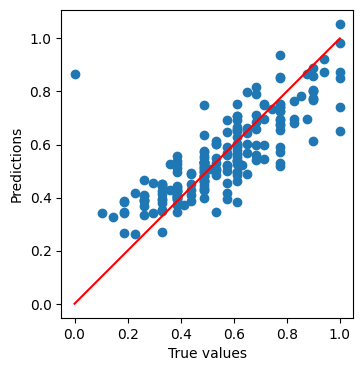

In [21]:
test_predictions = final_model.predict(X).flatten()
plt.figure(figsize=(4, 4))
plt.axes(aspect='equal')
plt.scatter(y, test_predictions)
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

In [22]:
with open('Outputs/ml_model.dill', 'wb') as file:
    dill.dump(final_model, file)

# Feature importance

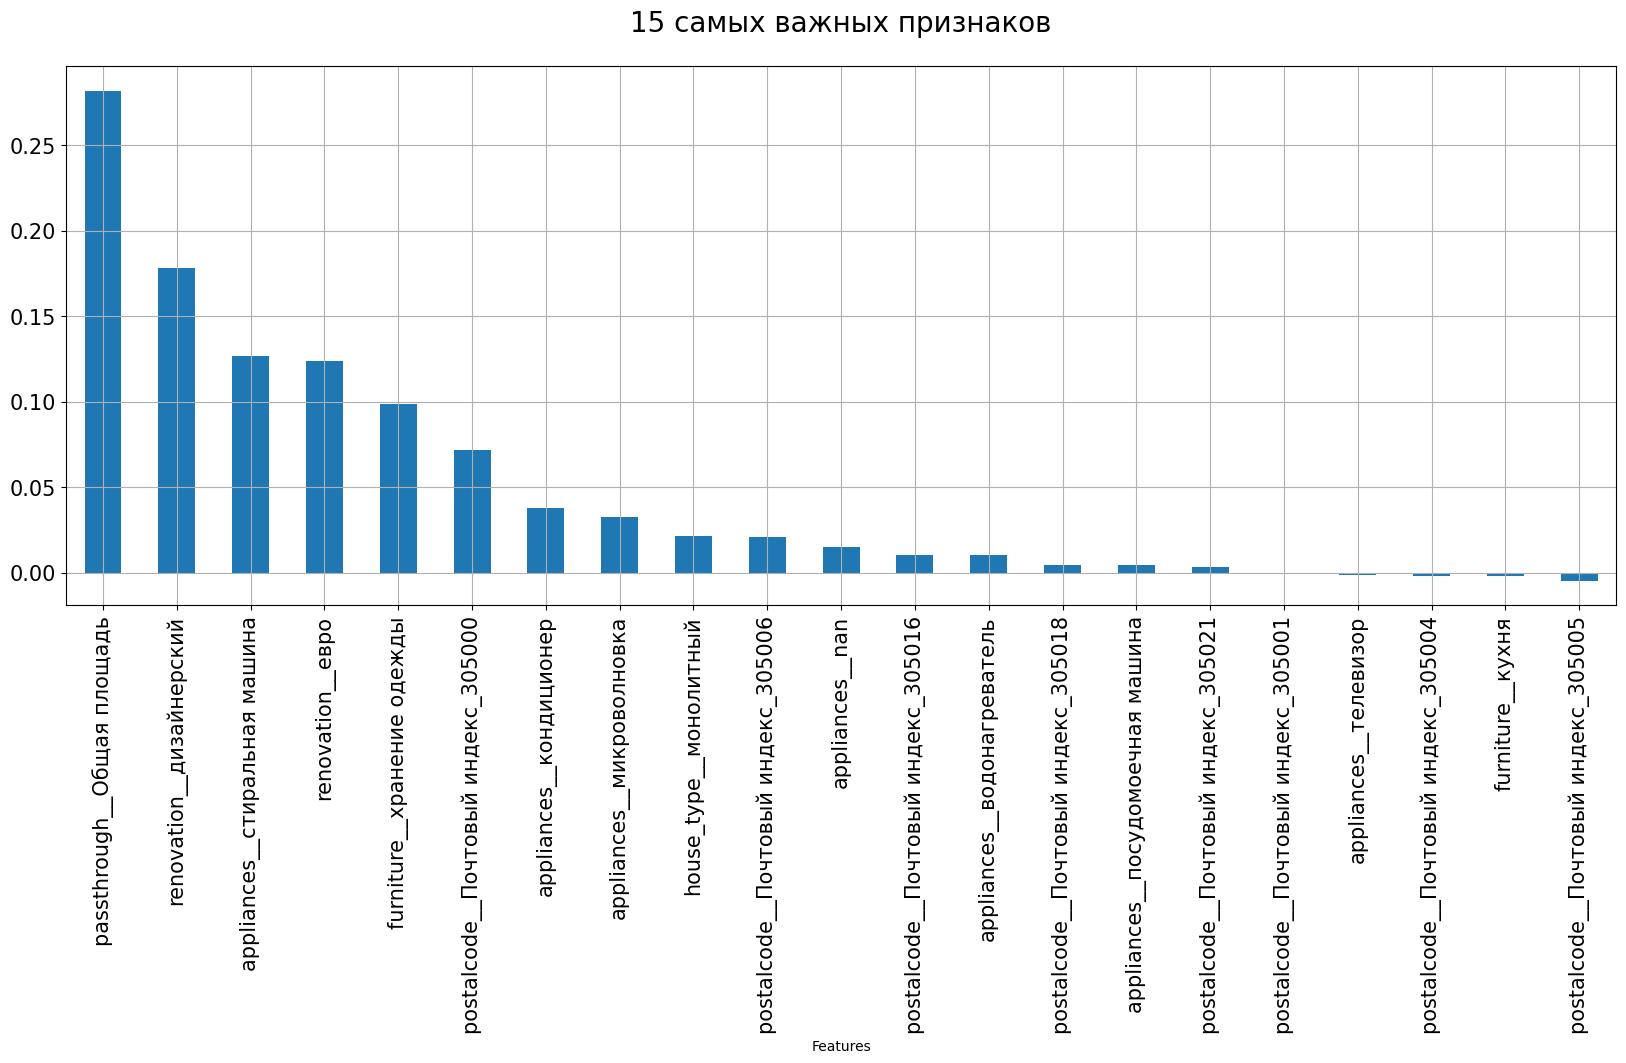

In [23]:
permutation_importances = permutation_importance(
    final_model, X_test, y_test, n_repeats=10, random_state=1)

perm_df = pd.DataFrame((permutation_importances['importances_mean'], X.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')#[:15]
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('15 самых важных признаков', fontsize=20, y=1.05)
plt.show()